# Logrank with Imprint


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [2]:
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n = all_rvs.shape[0]
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)
    # To match with the lifelines implementation, we square everything. This is
    # a weird because it means that a one sided test is impossible.
    # To match with the C++ imprint implementation, we don't square anything.
    # This seems obviously better because otherwise a one sided test would be
    # impossible.
    # return jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom


In [14]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = theta[:, 0]
        treatment_hazard = theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        control_rvs = jnp.tile(self.samples[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = self.samples[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        print(theta.shape, all_rvs.shape, self.group.shape, self.censoring_time)
        test_stat = self.vmap_logrank_test(
            all_rvs, self.group, self.censoring_time
        )
        return test_stat

In [15]:
g = ip.cartesian_grid([1, 1], [1, 1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1674868756, n_bits=18, worker_bits=18) = [4415640071538212864, ...]:


In [16]:
lr = LogRank(0, 10000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

[1.]
(1, 2) (1, 10000, 200) (10000, 200) 10000000


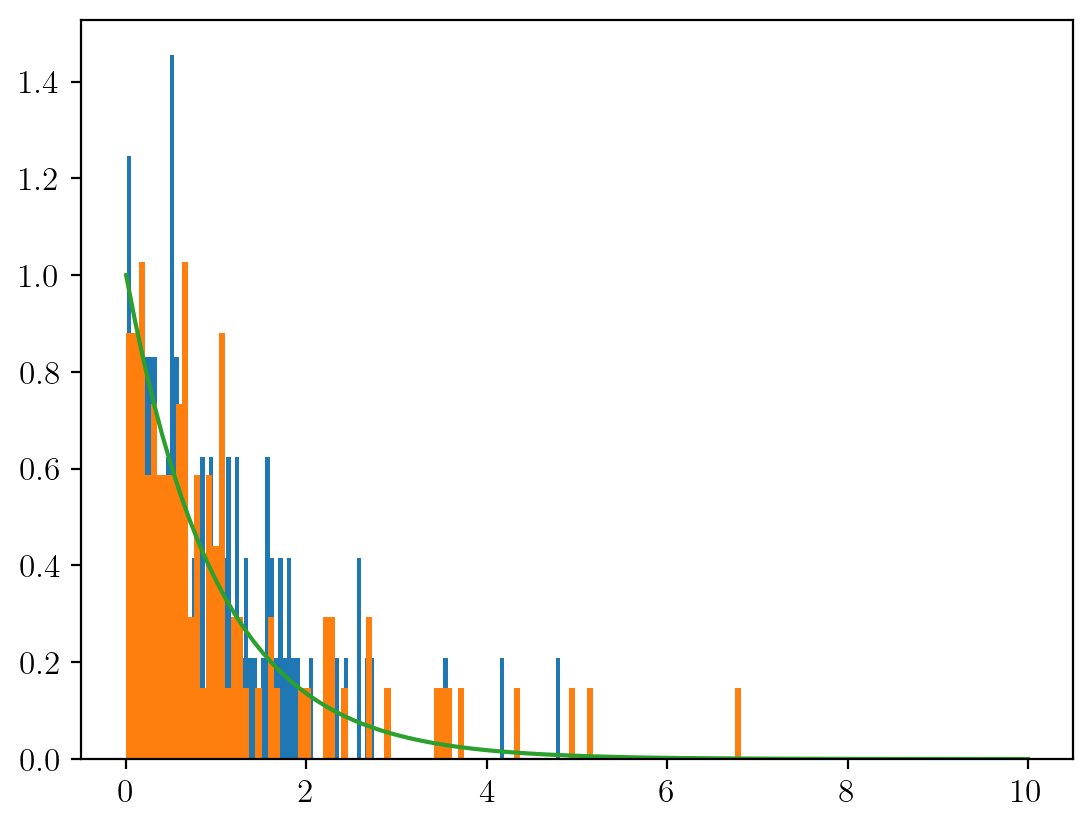

In [17]:
# plot lr.samples[0,:,0] and lr.samples[0,:,1] on the same plot
plt.figure()
plt.hist(lr.samples[0,:,0], bins=100, density=True, label='control')
plt.hist(lr.samples[0,:,1], bins=100, density=True, label='treatment')
# and compare to an exponential distribution with lambda = 1
x = jnp.linspace(0, 10, 100)
plt.plot(x, scipy.stats.expon.pdf(x), label="exponential")

plt.show()

The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

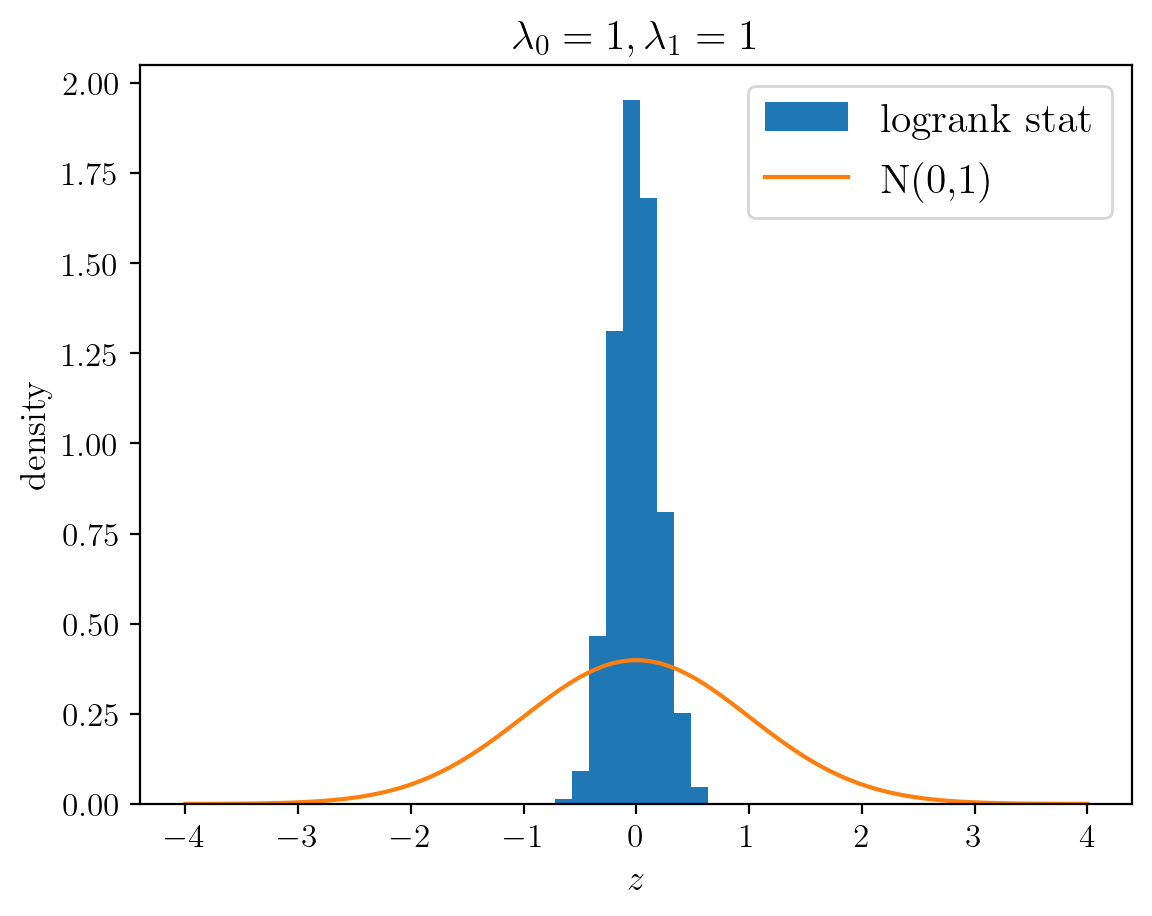

In [22]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), density=True, label='logrank stat')
xs = np.linspace(-4, 4, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [37]:
g = ip.cartesian_grid([0.5, 0.5], [2, 2], n=[20, 20], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1674869837, n_bits=18, worker_bits=18) = [4415714357292564480 4415714357292564481 4415714357292564482, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1674869838, n_bits=18, worker_bits=18) = [4415714426012041216 4415714426012041217 4415714426012041218, ...]:


In [38]:
rej_df = ip.validate(LogRank, g=g, lam=-0.2, model_kwargs=dict(n=30, censoring_time=12))

[1.         0.87755102 0.78181818 0.70491803 0.64179104 0.5890411  0.5443038  0.50588235 0.47252747
 0.44329897 0.41747573 0.39449541 0.37391304 0.3553719  0.33858268 0.32330827 0.30935252 0.29655172
 0.28476821 0.27388535 0.89090909 0.80327869 0.73134328 0.67123288 0.62025316 0.57647059 0.53846154
 0.50515464 0.47572816 0.44954128 0.42608696 0.40495868 0.38582677 0.36842105 0.35251799 0.33793103
 0.32450331 0.31210191 0.90163934 0.82089552 0.75342466 0.69620253 0.64705882 0.6043956  0.56701031
 0.53398058 0.50458716 0.47826087 0.45454545 0.43307087 0.41353383 0.39568345 0.37931034 0.36423841
 0.35031847 1.         0.91044776 0.83561644 0.7721519  0.71764706 0.67032967 0.62886598 0.59223301
 0.55963303]
(64, 2) (64, 16384, 60) (16384, 60) 12
[0.53043478 0.50413223 0.48031496 0.45864662 0.43884892 0.42068966 0.40397351 0.38853503 0.91780822
 0.84810127 0.78823529 0.73626374 0.69072165 0.65048544 0.6146789  0.5826087  0.55371901 0.52755906
 0.5037594  0.48201439 0.46206897 0.44370861 0.4

In [39]:
rej_df

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,2636,0.160889,0.167679,0.035155
1,1231,0.075134,0.080059,NaN
2,551,0.033630,0.037052,NaN
3,261,0.015930,0.018356,NaN
4,99,0.006042,0.007606,NaN
...,...,...,...,...
215,2636,0.160889,0.167679,0.104688
216,2636,0.160889,0.167679,0.106908
217,2636,0.160889,0.167679,0.108980
218,2636,0.160889,0.167679,0.110918


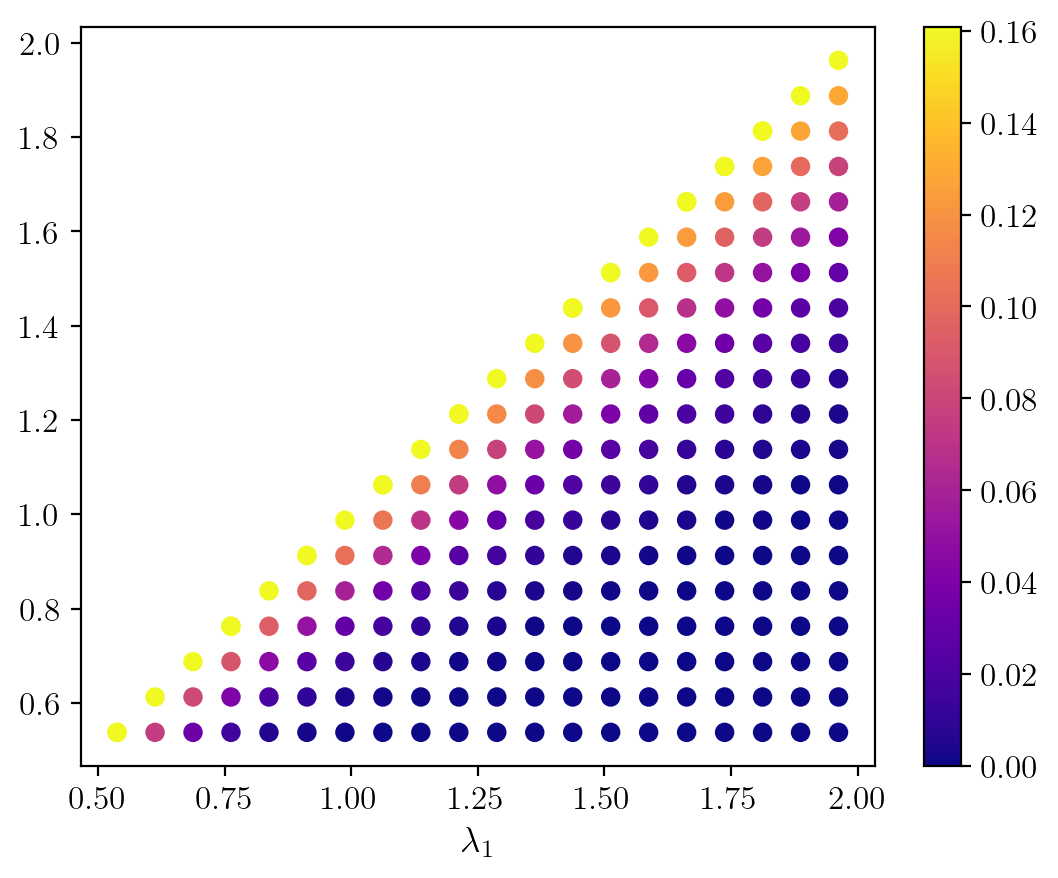

In [40]:
import matplotlib.pyplot as plt
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.xlabel('$\lambda_1$')
plt.colorbar()
plt.show()